# Example DAGRunner usage

Let's demonstrate defining a callable object which represents some processing step we wish to do, along with a minimal networkx graph which describes a network of processing steps and their relationship to one another.  Our example will demonstrate the following:

- Defining a callable object to be executed for a given node in our graph.
  - Passing data in memory.
- Defining a minimal networkx graph.
  - Defining an example node identity for our networkx graph.
- Execution of our graph with our chosen scheduler.

The currency of DAGRunner is the [networkx.DiGraph](https://networkx.org/documentation/stable/reference/classes/digraph.html) object.  DAGRunner is provided this networkx graph object (or python dot path to one) and told to execute it with a specified scheduler.  A layer of abstraction is provided to support range of schedulers.
The question becomes, "how does DAGRunner know what and how to execute my networkx graph?"

By default, DAGRunner pre-defines a default [plugin-executor](https://github.com/MetOffice/dagrunner/blob/main/docs/dagrunner.execute_graph.md#function-plugin_executor) function.  Each node in your networkx graph when 'executed' by DAGRunner is wrapped by this function.  It's purpose is in taking the node properties and attributes provided along with any data from ancestor nodes and using this to inform how to call our processing step and with what argument.  We will go into some detail later.

## Pre-requisites

Ensure that 'dagrunner' is on the `PYTHONPATH` (i.e. [installation](../README.md#installation)).

## Defining a processing step (AKA something to execute, processing module or 'plugin')

First, let's define some callable that represents some processing step.  This callable will take positional arguments which represent the values from returned by direct ancestor nodes to the one being executed.  The callable will typically do something to manipulate the data provided before returning this as a result, ready for descendant nodes to further process this data.
By our callable returning an object, we are passing data in memory along the node tree.

To that end, we define a simple callable that will additionally accept an ID keyword argument.  Our callable will concatenate the node ID values provided to it from proceeding nodes (args) with its own node ID value and so the concatenated node ID strings will be the basis of this data passed between nodes in our network.

DAGRunner provide some powerful built-in plugins; some are abstract classes like `Plugin` and `Load`, while others are intended as useful for use directly, such as `DataPolling`, `Input`, `LoadJson`, `SaveJson`, `LoadPickle` and `SavePickle`.  See [here](dagrunner.plugin_framework.md) for more information.

For simplicity, we will define a simple function as our callable.

In [1]:
def concatenate_id(*args, id=None):
    """Concatenate node IDs together"""
    concat_arg_id = str(id)
    if args and args[0]:
        concat_arg_id = '_'.join([str(arg) for arg in args if arg]) + f"_{id}"
    return concat_arg_id

## NetworkX graph definition

A networkx graph is constructed from a list of edges (see official [edge](https://networkx.org/documentation/stable/reference/glossary.html#term-edge) definition) and/or nodes (see official [node](https://networkx.org/documentation/stable/reference/glossary.html#term-node) definition).  We highly recommend a general reading of the official documentation around the topic, but in short, a graphs nodes represents its identities and the edges represent the relationship/connectivity between these identities.

Often we additionally use the term 'settings'.  This is to mean a mapping (dictionary) between node identity and its attributes (see official [node attributes](https://networkx.org/documentation/stable/reference/glossary.html#term-node-attribute) definition).  It's these node attributes that inform DAGRunnder via it's internal [plugin-executor](https://github.com/MetOffice/dagrunner/blob/main/docs/dagrunner.execute_graph.md#function-plugin_executor) on how to execute a given node.  We will go through this in our example.

### Define a 'node' identiy for our NetworkX graph

We are free to define our node (graph identities) in any way we choose.  However, we highly recommend the use of immutable containers such as [dataclasses](https://docs.python.org/3/library/dataclasses.html#dataclasses.dataclass) or [namedtuples](https://docs.python.org/3/library/collections.html#collections.namedtuple).  These are highly effective means for representing node identities using flexible immutable objects.

Let's define a 'Node' [dataclasses](https://docs.python.org/3/library/dataclasses.html#dataclasses.dataclass) class to use for identities within our networkx graph.

We can define any number of 'properties', but we will stick with 'step' and 'leadtime' for now as this will suffice in our basic example.

We will additionally define a `__str__` special method too, as this will enable useful labels in our visualisation of the networkx graph later.

In [2]:
from dataclasses import dataclass

@dataclass(order=True, eq=True, frozen=True)
class Node:
    step: str = None
    leadtime: int = None

    def __str__(self):
        return f"S:{self.step}_L:{self.leadtime}"

### Define a networkx graph

Here, we will demonstrate defining a graph with two independent branches of execution, each identified by its own 'leadtime', as we defined in our object used to define the node identity above.

Note: The networkx graph is most often referred to as the 'configuration' or 'recipe', when discussed within the scope of an orchestration engine.  This is important as 'graph' is rather ambiguous and dependent on the context and layer we are referring.

In [3]:
HOUR = 3600
MINUTE = 60
leadtimes = tuple(range(0, HOUR*2, HOUR))

SETTINGS = {}
EDGES = []

for leadtime in leadtimes:
    # node1 -> node2
    node1 = Node(step="step1", leadtime=leadtime)
    node2 = Node(step="step2", leadtime=leadtime)
    EDGES.append((node1, node2))

    # node3 -> node4
    node3 = Node(step="step3", leadtime=leadtime)
    node4 = Node(step="step4", leadtime=leadtime)
    EDGES.append((node3, node4))

    # node2 -> node5
    node5 = Node(step="step5", leadtime=leadtime)
    EDGES.append((node2, node5))

    # node4 -> node5
    node4 = Node(step="step4", leadtime=leadtime)
    EDGES.append((node4, node5))

    for nodenum in range(1, 6):
        node = vars()[f"node{nodenum}"]
        SETTINGS[node] = {
            'call': (concatenate_id, {"id": nodenum}),
        }

Let's look at what we have just defined.  Some edges and some settings*

*reminder that by settings, we mean a `{node, attributes}` lookup.

In [4]:
from pprint import pprint
print('edges:')
pprint(EDGES)
print('\nsettings:')
pprint(SETTINGS)

edges:
[(Node(step='step1', leadtime=0), Node(step='step2', leadtime=0)),
 (Node(step='step3', leadtime=0), Node(step='step4', leadtime=0)),
 (Node(step='step2', leadtime=0), Node(step='step5', leadtime=0)),
 (Node(step='step4', leadtime=0), Node(step='step5', leadtime=0)),
 (Node(step='step1', leadtime=3600), Node(step='step2', leadtime=3600)),
 (Node(step='step3', leadtime=3600), Node(step='step4', leadtime=3600)),
 (Node(step='step2', leadtime=3600), Node(step='step5', leadtime=3600)),
 (Node(step='step4', leadtime=3600), Node(step='step5', leadtime=3600))]

settings:
{Node(step='step1', leadtime=0): {'call': (<function concatenate_id at 0x7fce88488720>,
                                           {'id': 1})},
 Node(step='step1', leadtime=3600): {'call': (<function concatenate_id at 0x7fce88488720>,
                                              {'id': 1})},
 Node(step='step2', leadtime=0): {'call': (<function concatenate_id at 0x7fce88488720>,
                                        

We see that each node executed is provided our 'call', from the nodes attributes dictionary.
It's value is `(callable, callable_keyword_arguments)`.
This 'callable' is what represents the object to be executed or python module dot path to it.  As mentioned previously, see [plugin-executor](https://github.com/MetOffice/dagrunner/blob/main/docs/dagrunner.execute_graph.md#function-plugin_executor) for further details on how this works.

## Execute our graph

To execute our graph, we will make use of the built-in [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) class.
This class accepts our [networkx.DiGraph](https://networkx.org/documentation/stable/reference/classes/digraph.html) object as input.  It can also optionally take a tuple `(edges, nodes)`, which in turn DAGRunner will turn into a [networkx.DiGraph](https://networkx.org/documentation/stable/reference/classes/digraph.html) for us.  We typically recommend that users pass DAGRunner the networkx graph itself, but for simplicity, we will stick with our tuple.

Furthermore, we will specify the 'single-threaded' scheduler to begin with.  This is the dask serial execution scheduler.

In [5]:
from dagrunner.execute_graph import ExecuteGraph
graph = ExecuteGraph((EDGES, SETTINGS), scheduler="single-threaded", verbose=True)

### Graph visualisation

We provide some out-of-the-box capability to easily visualise networkx graphs (using the javascript mermaid library).

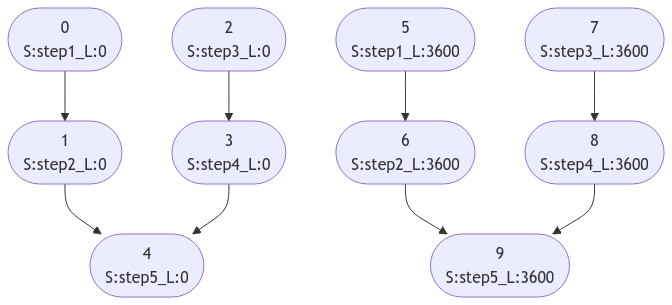

In [6]:
graph.visualise()

We can clearly see the two distinct branches for execution, one for each leadtime that we defined.

### Execution

Now, let's execute this graph and seeing how things progress through the execution (we specified `verbose=True` above).

In [7]:
graph()

args: []
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 1})
concatenate_id(*[], **{'id': 1})
result: 1
args: ['1']
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 2})
concatenate_id(*['1'], **{'id': 2})
result: 1_2
args: []
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 3})
concatenate_id(*[], **{'id': 3})
result: 3
args: ['3']
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 4})
concatenate_id(*['3'], **{'id': 4})
result: 3_4
args: ['1_2', '3_4']
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 5})
concatenate_id(*['1_2', '3_4'], **{'id': 5})
result: 1_2_3_4_5
args: []
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 3})
concatenate_id(*[], **{'id': 3})
result: 3
args: ['3']
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 4})
concatenate_id(*['3'], **{'id': 4})
result: 3_4
args: []
call: (<function concatenate_id at 0x7f8c5defc0e0>, {'id': 1})
concatenate_id(*[], **{'id': 1})
result: 1
args: ['1']
call: (<func

We can see from the stdout: 'args' representing input arguments to our particular node; 'call', the attribute representing how to execute this node and 'result', the concatenation of node ID performed by our callable (`concatenate_id`).  This demonstrates passing data in memory (node ID strings in this case) between nodes in the execution graph.

## Customisation

### Customised graph construction

"What if I require some degree of control over how the graph is constructed based on how its called?"

The [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) class can also be provided a **callable object** which returns a networkx graph.  As mentioned previously, similarly, this can be a python dot module path to such a callable object too.  When providing a callable that returns a networkx graph, rather than the networkx graph directly, you may want to such a callable to accept parameters too.  This is a means for context dependent graph construction as well as lazy graph construction.  Parameters to our callable are provided to [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) via the `networkx_graph_kwargs` parameter.

This offers huge amounts of flexibility and importantly ensures that a separation of concerns is maintained.  That is, that DAGrunner only concerns itself with providing a framework by which to execute networkx graphs, rather than taking responsibility to define such a graph.

Typical usecases include:
- Lazy graph construction.
  - Being a callable means we benefit from lazy construction, where the graph callable to construct your graph isn't itself called until execution of the graph.
- Context dependent graph construction.
  - Cycle dependent graph construction.
  - ...

Here is an example, where we might request a networkx graph which is constructed which is dependent on the particular cycle to which we are executing:

```python
def gen_networkx(cycle):
    graph = graph_gen(cycle)
    return graph
```

This calls a fictitious `graph_gen`.  Representing something you have defined that returns your cycle dependent networkx graph construction.

We can then instantiate our `ExecuteGraph` object accordingly with this graph construction callable object and pass any parameters it should take (like the cycle in this case):

```python
graph = ExecuteGraph(gen_networkx, networkx_graph_kwargs={"cycle": dummy_cycle})
```

We can see how we might achieve great amount of flexibility through such an approach, allowing us to meet project specific needs.

### Customised node execution

We mentioned previously how DAGRunner [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) class by default utilises its built-in [plugin-executor](https://github.com/MetOffice/dagrunner/blob/main/docs/dagrunner.execute_graph.md#function-plugin_executor) function to execute each node that it wraps in our networkx graph.

It is this function that defines what we expect to find defined for our graphs node attributes.  Defining the need for this 'call' attribute in particular which tells it what callable object to call, along with any arguments to pass to it.  This callable object can be the object itself, or otherwise again a python doc path to this object.

We can of course define our own 'plugin executor' and pass this on initialisation of our [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) class.

However, this should not normally be needed.  We provide an illustrated example here for completeness.  In our example, we will extend the built-in executor rather than replace it:

In [8]:
from dagrunner.execute_graph import ExecuteGraph, plugin_executor

def custom_plugin_executor(*args, call=None, verbose=False, dry_run=False, **kwargs):
    # do something custom
    return plugin_executor(*args, call=call, verbose=verbose, dry_run=dry_run, **kwargs)

Now we can utilise our project specific plugin executor by initialising our [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) class with this object.

```python
ExecuteGraph(..., plugin_executor=custom_plugin_executor, ...)
```

### Further customisation

Note that you may choose to subclass [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph) and or write a custom commandline script to call it, depending on your requirements.

As with the case of a custom `plugin_executor``, it's unlikely that you will find such a need for customisation such as this.

## Using DAGrunner via the commandline

Using DAGrunner as part of real world scenarios will likely require interfacing to it externally.  This can be done via the commandline.

DAGRunner provides the `dagrunner-execute-graph` script for this purpose.

This script provides a CLI that maps 1-to-1 with the UI of [ExecuteGraph](docs/dagrunner.execute_graph.md#class-executegraph), so everything described above can be repeated via the commandline via this script.

The only difference when calling via this script, is that clearly our networkx graph (or callable that returns one), must be provided via a string representing a Python dot path to this object, rather than the object itself.  DAGRunner will then module load this object accordingly.